In [1]:
# Impor library yang diperlukan
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# --- 1. Memuat dan Mempersiapkan Data ---
# Gunakan file CSV baru Anda dengan label 0-25
file_path = 'Data.csv'
# Specify the semicolon delimiter
df = pd.read_csv(file_path, delimiter=';')

print("Contoh Data:")
print(df.head())
print("\nInfo Data:")
df.info()
print("\nJumlah Sampel untuk Setiap Kelas:")
print(df['ClassID'].value_counts().sort_index())

# Pisahkan fitur (X) dan label (y)
X = df.drop('ClassID', axis=1).values
y = df['ClassID'].values

# Tentukan kolom fitur untuk digunakan saat menyimpan nilai normalisasi
features_columns = df.drop('ClassID', axis=1).columns.tolist()

Contoh Data:
   Flex5  Flex4  Flex3  Flex2  Flex1  AccelX  AccelY  AccelZ  GyroX  GyroY  \
0   1421   1200   1114   1109    818    0.15    0.99    0.12   0.03  -0.04   
1   1431   1207   1109   1118    805    0.16    1.00    0.15  -0.01   0.02   
2   1456   1232   1118   1113    844    0.17    0.98    0.14  -0.03  -0.03   
3   1417   1269   1079   1136    816    0.14    0.99    0.14   0.00  -0.04   
4   1463   1198   1077   1107    831    0.16    0.99    0.14   0.02  -0.02   

   GyroZ  ClassID  
0   0.01        0  
1   0.01        0  
2   0.00        0  
3  -0.01        0  
4   0.01        0  

Info Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10400 entries, 0 to 10399
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Flex5    10400 non-null  int64  
 1   Flex4    10400 non-null  int64  
 2   Flex3    10400 non-null  int64  
 3   Flex2    10400 non-null  int64  
 4   Flex1    10400 non-null  int64  
 5   AccelX

In [3]:
# --- 2. Normalisasi Fitur ---
# Pisahkan data menjadi set training dan testing/validasi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Buat dan fit StandardScaler HANYA pada data training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simpan nilai means dan standard deviations untuk digunakan di ESP32
means = scaler.mean_
std_devs = scaler.scale_

print("\n--- Nilai untuk Normalisasi di ESP32 ---")
print("const float MEANS[] = {")
print(", ".join([f"{val:.4f}" for val in means]) + "};")
print("const float STD_DEVS[] = {")
print(", ".join([f"{val:.4f}" for val in std_devs]) + "};")
print("Urutan Fitur:", features_columns)
print("----------------------------------------\n")


--- Nilai untuk Normalisasi di ESP32 ---
const float MEANS[] = {
1428.4070, 1627.8153, 1347.8956, 1253.6952, 1075.7409, 0.0590, 0.8313, 0.2896, -0.0088, -0.0091, 0.0043};
const float STD_DEVS[] = {
222.1246, 281.9704, 246.7781, 179.0070, 270.2374, 0.2106, 0.3776, 0.2201, 0.2350, 0.6496, 0.2731};
Urutan Fitur: ['Flex5', 'Flex4', 'Flex3', 'Flex2', 'Flex1', 'AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ']
----------------------------------------



In [4]:
# --- 3. [Opsional] Windowing dan Flattening (jika Anda ingin menangkap pola waktu) ---
X_train_final = X_train_scaled
y_train_final = y_train
X_test_final = X_test_scaled
y_test_final = y_test

NUM_FEATURES = X_train_final.shape[1]
NUM_CLASSES = len(np.unique(y))

In [8]:
# --- 4. Membangun Model ANN yang Ditingkatkan ---
def create_enhanced_ann_model(num_features, num_classes):
    model = Sequential([
        Input(shape=(num_features,), name='input_layer'),

        Dense(128, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        Dropout(0.4),

        Dense(64, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        Dropout(0.3),

        Dense(64, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        Dropout(0.2),

        Dense(num_classes, activation='softmax', name='output_layer')
    ])
    return model

# Buat model
model = create_enhanced_ann_model(NUM_FEATURES, NUM_CLASSES)

# Kompilasi model dengan learning rate yang mungkin sedikit lebih rendah
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,666 (65.10 KB)

 Trainable params: 16,154 (63.10 KB)

 Non-trainable params: 512 (2.00 KB)

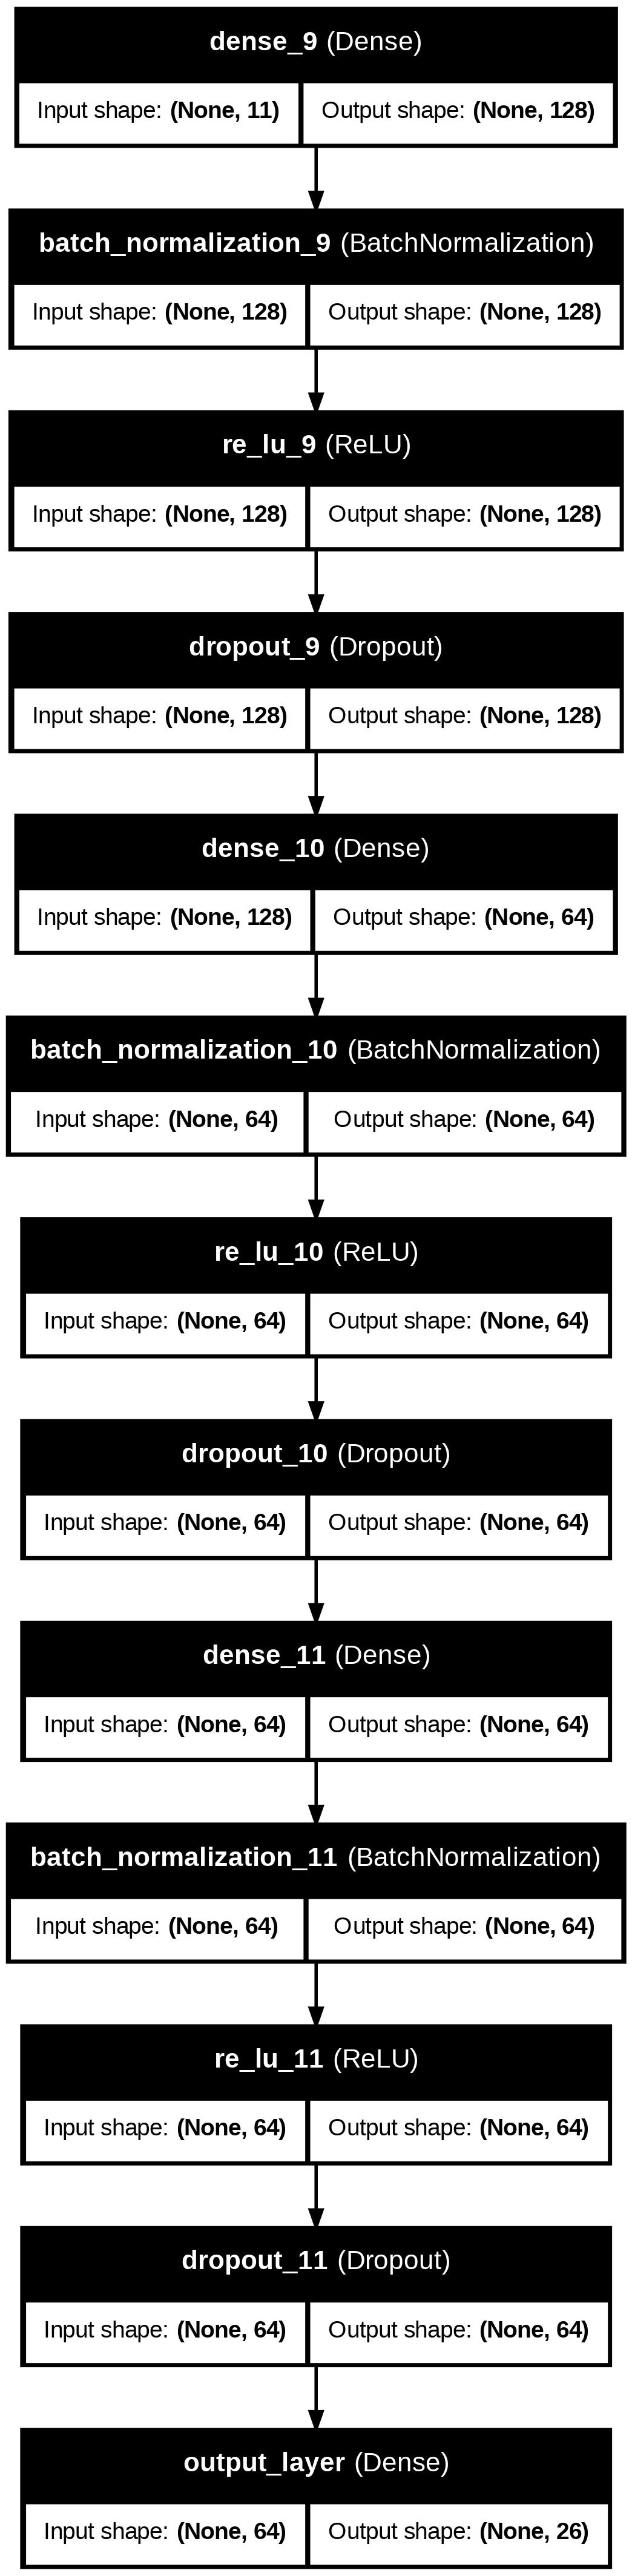

In [10]:
# Generate and save the model plot
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Display the generated image in the notebook
from IPython.display import Image
display(Image(filename='model.png', width=400, height=1800)) # Adjusted width and height

In [11]:
# --- 5. Melatih Model ---
# Callbacks untuk menyimpan model terbaik dan menghentikan training lebih awal
model_checkpoint = ModelCheckpoint('sibi_ann_model_enhanced.keras', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_final,
    y_train_final,
    epochs=25,
    batch_size=32,
    validation_data=(X_test_final, y_test_final),
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/25
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.0611 - loss: 3.5499 - val_accuracy: 0.4048 - val_loss: 2.8934
Epoch 2/25
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2014 - loss: 2.9200 - val_accuracy: 0.6096 - val_loss: 2.3174
Epoch 3/25
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3322 - loss: 2.5342 - val_accuracy: 0.7716 - val_loss: 1.9217
Epoch 4/25
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4640 - loss: 2.1837 - val_accuracy: 0.9010 - val_loss: 1.6133
Epoch 5/25
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5516 - loss: 1.9416 - val_accuracy: 0.9082 - val_loss: 1.3609
Epoch 6/25
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6032 - loss: 1.7231 - val_accuracy: 0.9178 - val_loss: 1.1463
Epoch 7/25
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6640 - loss: 1.5334 - val_accuracy: 0.9399 - val_loss: 0.9748
Epoch 8/25
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6775 - loss: 1.3944 - val_accuracy: 0

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9983 - loss: 0.2595

Akurasi pada data test: 99.62%


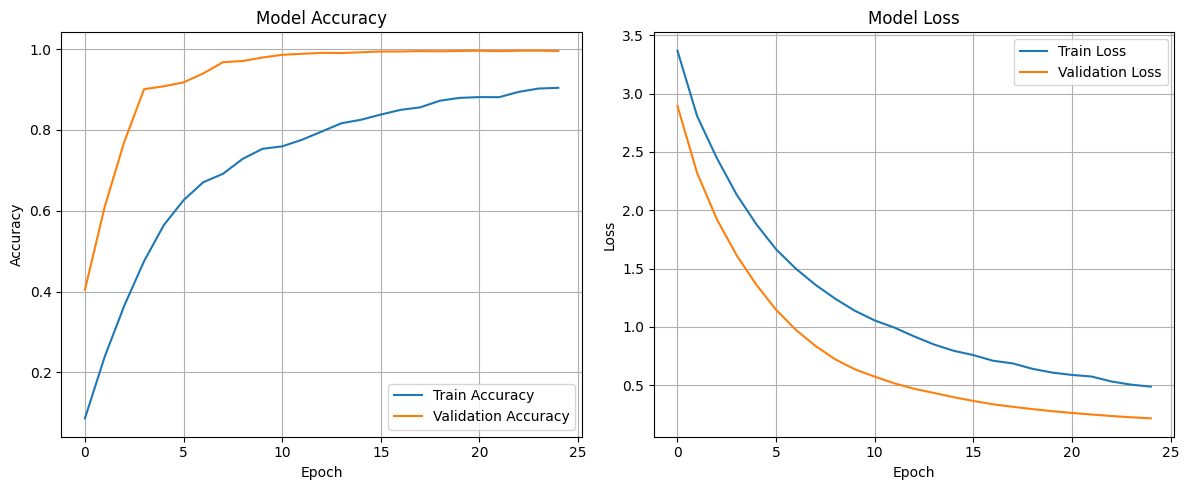

In [21]:
# --- 6. Evaluasi Model ---
# Muat model terbaik yang disimpan
best_model = tf.keras.models.load_model('sibi_ann_model_enhanced.keras')

# Evaluasi pada data test
test_loss, test_accuracy = best_model.evaluate(X_test_final, y_test_final)
print(f"\nAkurasi pada data test: {test_accuracy*100:.2f}%")

# Plot hasil training
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5)) # Sedikit diperbesar untuk kejelasan

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- Confusion Matrix ---


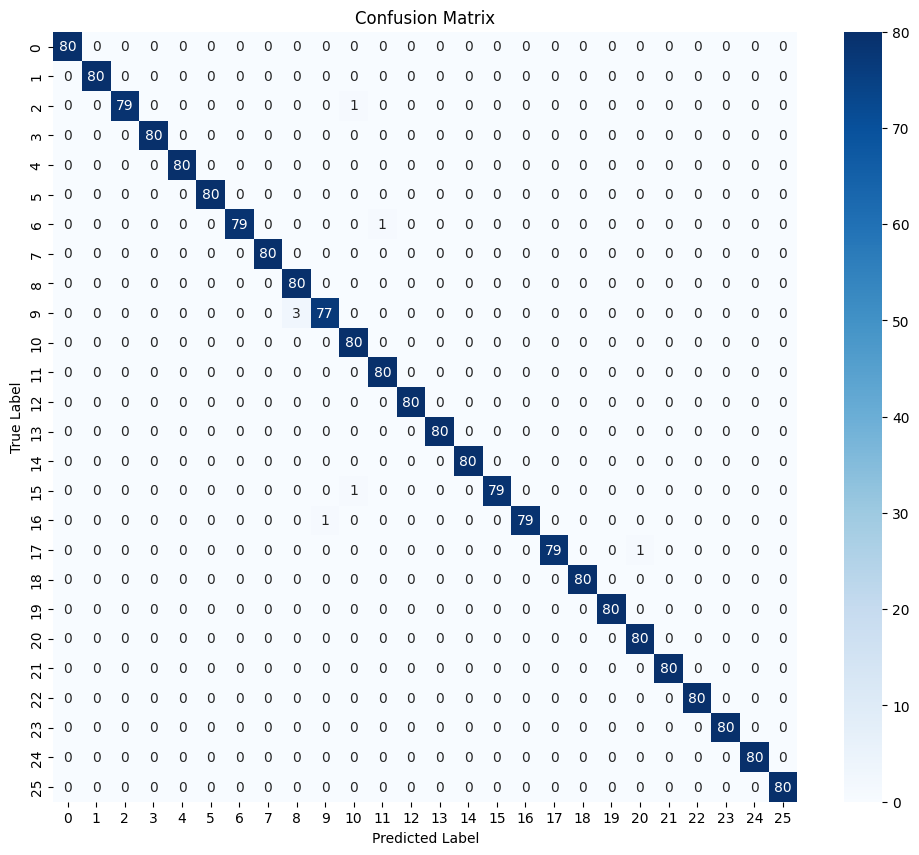

In [14]:
# --- 7. Prediksi dan Analisis Tambahan (Optional) ---
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions for the test set
y_pred_probs = best_model.predict(X_test_final)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test_final, y_pred)

# Define class_names based on the unique values in the original 'ClassID' column
# Assuming 'df' contains the original data and 'ClassID' is the column with class labels
if 'df' in locals() and 'ClassID' in df.columns:
    class_names = sorted(df['ClassID'].unique())
else:
    # Fallback if df or 'ClassID' is not available, though it should be based on the notebook state
    # In this case, we'll just create generic class names
    class_names = [str(i) for i in range(NUM_CLASSES)] # Use NUM_CLASSES defined earlier


# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# --- Classification Report ---
print("\n--- Classification Report ---")
# Generate class labels based on the unique classes in y_test_final
# Assuming y_test_final contains the actual class indices (0-25)
class_labels = [str(i) for i in sorted(np.unique(y_test_final))]
print(classification_report(y_test_final, y_pred, target_names=class_labels))


--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00        80
           2       1.00      0.99      0.99        80
           3       1.00      1.00      1.00        80
           4       1.00      1.00      1.00        80
           5       1.00      1.00      1.00        80
           6       1.00      0.99      0.99        80
           7       1.00      1.00      1.00        80
           8       0.96      1.00      0.98        80
           9       0.99      0.96      0.97        80
          10       0.98      1.00      0.99        80
          11       0.99      1.00      0.99        80
          12       1.00      1.00      1.00        80
          13       1.00      1.00      1.00        80
          14       1.00      1.00      1.00        80
          15       1.00      0.99      0.99        80
          16       1.00      0.99      0.99       

In [17]:
# Tampilkan beberapa prediksi vs label asli
print("\n--- Sample Predictions ---")
for i in range(10): # Tampilkan 10 sampel pertama
    # Access y_test using positional index .iloc[i]
    print(f"Sample {i+1}: Actual ClassID = {y_test_final[i]+1}, Predicted ClassID = {y_pred[i]+1}")


--- Sample Predictions ---
Sample 1: Actual ClassID = 26, Predicted ClassID = 26
Sample 2: Actual ClassID = 25, Predicted ClassID = 25
Sample 3: Actual ClassID = 15, Predicted ClassID = 15
Sample 4: Actual ClassID = 14, Predicted ClassID = 14
Sample 5: Actual ClassID = 4, Predicted ClassID = 4
Sample 6: Actual ClassID = 20, Predicted ClassID = 20
Sample 7: Actual ClassID = 22, Predicted ClassID = 22
Sample 8: Actual ClassID = 18, Predicted ClassID = 18
Sample 9: Actual ClassID = 2, Predicted ClassID = 2
Sample 10: Actual ClassID = 16, Predicted ClassID = 16


In [18]:
!pip install "everywhereml>=0.2.32"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 6.3 MB/s eta 0:00:00
  Created wheel for everywhereml: filename=everywhereml-0.2.40-py3-none-any.whl size=81188 sha256=a669b03b3b1acf35a98e4793f3cf5b9d2c1ebd387ef2f21c32fa7fc3d04e4076
  Stored in directory: /root/.cache/pip/wheels/56/00/11/b20220191cc74f61c78967a3614c6f58f53b6078f48dd35976
  Created wheel for hexdump: filename=hexdump-3.3-py3-none-any.whl size=8894 sha256=922cc114328b5438ff4664fbb17fd0ffe03f7cf51b9c76d496d0793ede07e79a
  Stored in directory: /root/.cache/pip/wheels/67/21/60/6c8dd0e145d13fd9501e1078cfd8aa34069f022cf4cdda6b0f
Successfully built everywhereml hexdump


In [19]:
"""
Export NN to C++
Copy-paste the generated code inside a file named model.h or irisModel.h
in your Arduino project
"""
from everywhereml.code_generators.tensorflow import convert_model
import tensorflow as tf # Import tensorflow for one-hot encoding

# Use the normalized training data as the representative dataset for C++ export
# convert_model needs input data to understand feature scaling/ranges for C++ generation
X_np = X_test_final # Changed from X.values to X_train_normalized

# One-hot encode the target variable for the C++ conversion
# Assuming NUM_CLASSES is the total number of classes
y_train_one_hot = tf.keras.utils.to_categorical(y_test_final, num_classes=26)

# Use the loaded best model (best_model_ann_loaded) for conversion
# Pass the one-hot encoded y to the convert_model function
c_header = convert_model(best_model, X_np, y_train_one_hot, model_name='TA_Model')
print(c_header)

Saved artifact at '/tmp/tmpg65owalf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 11), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  138821544755024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138821544754832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138821532142096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138821532141904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138821532142864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138821532142480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138821532143056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138821532143248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138821532142288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138821608265424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138821532139792: Tensor

In [20]:
with open('MODEL.h', 'w') as f:
        f.write(c_header)